In [ ]:
import torch
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, TrainingArguments, Trainer
from datasets import load_dataset
!pipn install evaluate
import evaluate
import matplotlib.pyplot as plt

/bin/bash: line 1: pipn: command not found


In [ ]:
import os
cache_dir = os.path.expanduser("~/.cache/huggingface/datasets")
if os.path.exists(cache_dir):
    import shutil
    shutil.rmtree(cache_dir)
    print("Cleared dataset cache.")

Cleared dataset cache.


In [ ]:
!pip install -U datasets

In [ ]:
# TODO: Load tokenizer and set pad_token
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# TODO: Load model configuration and model
config = AutoConfig.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")

# TODO: Load SQuAD dataset and create train/validation splits
dataset = load_dataset("squad",cache_dir="./hf_datasets")
vali_ds = dataset["validation"].select(range(5))
split_ds = dataset["train"].train_test_split(test_size=0.1, shuffle=True)
train_ds = split_ds["train"].shuffle(seed=42).select(range(2000))
eval_ds = split_ds["test"].shuffle(seed=42).select(range(200))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
print(config)

GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.52.4",
  "use_cache": true,
  "vocab_size": 50257
}



In [ ]:
gc.collect()

154

In [ ]:
def preprocess_function(examples):
    """
    Creates properly aligned input-label pairs for causal LM fine-tuning

    Args:
        examples: Batch of SQuAD examples with 'context', 'question', 'answers'

    Returns:
        Dictionary with 'input_ids', 'attention_mask', 'labels'

    TODO: Implement the following steps:
    1. For each example, create a prompt: "Context: {context}\nQuestion: {question}\nAnswer: "
    2. Concatenate prompt + answer + eos_token
    3. Tokenize the full sequence
    4. Create labels by copying input_ids
    5. Mask prompt tokens in labels with -100 (so loss only computed on answer)

    > Creates properly aligned input-label pairs for causal LM fine-tuning
    with dynamic context truncation to ensure the answer is retained.
    """

    inputs = []

    for context, question, answers in zip(examples['context'], examples['question'], examples['answers']):
        answer_text = answers['text'][0] if answers['text'] else ""

        # Tokenize components separately
        context_ids = tokenizer(context, add_special_tokens=False)['input_ids']
        question_ids = tokenizer(question, add_special_tokens=False)['input_ids']
        answer_ids = tokenizer(answer_text, add_special_tokens=False)['input_ids']

        # Build static prompt part to estimate total size
        static_ids = tokenizer("Context: \nQuestion: \nAnswer: ", add_special_tokens=False)['input_ids']
        total_required = len(static_ids) + len(question_ids) + len(answer_ids) + 1  # +1 for EOS

        # Max tokens for context
        max_len = 512
        remaining = max_len - total_required
        context_ids = context_ids[:remaining] if remaining > 0 else []

        # Reconstruct text from truncated parts
        truncated_context = tokenizer.decode(context_ids, skip_special_tokens=True)
        prompt = f"Context: {truncated_context}\nQuestion: {question}\nAnswer: "
        full_text = prompt + answer_text + tokenizer.eos_token

        inputs.append(full_text)

    # Tokenize full input sequences
    model_inputs = tokenizer(
        inputs,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Mask prompt tokens in labels
    labels = []
    for i, input_ids in enumerate(model_inputs['input_ids']):
        input_id_list = input_ids.tolist()
        prompt = inputs[i].split("Answer:")[0] + "Answer: "
        prompt_ids = tokenizer(prompt, add_special_tokens=False)['input_ids']
        prompt_len = len(prompt_ids)

        label_ids = input_id_list[:]
        label_ids[:prompt_len] = [-100] * prompt_len
        labels.append(label_ids)

    model_inputs['labels'] = labels
    return model_inputs

In [ ]:
class QADataCollator:
    """
    Custom data collator for QA fine-tuning with proper padding
    """
    def __init__(self, tokenizer, max_length=512): # Changed max_length to 512
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, features):
        """
        Batching and padding:
        1. Extract input_ids, attention_mask, labels from each feature
        2. Pad sequences to max_length
        3. Use pad_token_id for input_ids, 0 for attention_mask, -100 for labels
        4. Return tensors
        """
        input_ids = [f["input_ids"] for f in features]
        attention_mask = [f["attention_mask"] for f in features]
        labels = [f["labels"] for f in features]

        # Pad inputs
        padded_inputs = self.tokenizer.pad(
            {"input_ids": input_ids, "attention_mask": attention_mask},
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Pad labels manually (because tokenizer.pad doesn't support label padding)
        padded_labels = []
        for lbl in labels:
            # Ensure label length matches max_length before padding
            lbl = lbl[:self.max_length] + [-100] * (self.max_length - len(lbl))
            padded_labels.append(lbl)


        padded_inputs["labels"] = torch.tensor(padded_labels, dtype=torch.long) # Ensure dtype is long

        return padded_inputs

In [ ]:
# Apply preprocessing to datasets
tok_train_ds = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names, batch_size=16)
tok_eval_ds = eval_ds.map(preprocess_function, batched=True, remove_columns=eval_ds.column_names, batch_size=16)

print(f"Training examples: {len(tok_train_ds)}")
print(f"Eval examples: {len(tok_eval_ds)}")

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Training examples: 2000
Eval examples: 200


## Setup LoRA configuration and model

In [ ]:
from peft import LoraConfig, TaskType, get_peft_model

# TODO: Freeze base model parameters
for param in model.parameters():
    model.requires_grad_(False)

### Experiments :

In [ ]:
lora_experiments = [
    {
        "name": "exp_r4_lr1e-4_attn",
        "r": 4,
        "alpha": 16,
        "dropout": 0.1,
        "learning_rate": 1e-4,
        "target_modules": ["c_attn"],
    },
    {
        "name": "exp_r8_lr2e-4_attn",
        "r": 8,
        "alpha": 16,
        "dropout": 0.1,
        "learning_rate": 2e-4,
        "target_modules": ["c_attn"],
    },
    {
        "name": "exp_r16_lr5e-4_attn",
        "r": 16,
        "alpha": 16,
        "dropout": 0.1,
        "learning_rate": 5e-4,
        "target_modules": ["c_attn"],
    },
    {
        "name": "exp_r8_lr2e-4_attn_mlp",
        "r": 8,
        "alpha": 16,
        "dropout": 0.1,
        "learning_rate": 2e-4,
        "target_modules": ["c_attn", "mlp.c_proj"],
    },
    {
        "name": "exp_r32_lr2e-4_attn_mlp",
        "r": 32,
        "alpha": 32,
        "dropout": 0.1,
        "learning_rate": 2e-4,
        "target_modules": ["c_attn", "mlp.c_proj"],
    }
]

In [ ]:
for i, lora_config_dict in enumerate(lora_experiments):
    print(f"Experiment {i+1}: {lora_config_dict['name']}")

    lora_config_dict = lora_experiments[i]
    print(lora_config_dict)

    lora_config = LoraConfig(
        r=lora_config_dict["r"],
        lora_alpha=lora_config_dict["alpha"],
        lora_dropout=lora_config_dict["dropout"],
        bias="none",
        task_type=TaskType.CAUSAL_LM,
        target_modules=lora_config_dict["target_modules"]
    )

    lora_model = get_peft_model(model, lora_config)
    lora_model.print_trainable_parameters()
    print("--------------------------------------------------------------------------------")

Experiment 1: exp_r4_lr1e-4_attn
{'name': 'exp_r4_lr1e-4_attn', 'r': 4, 'alpha': 16, 'dropout': 0.1, 'learning_rate': 0.0001, 'target_modules': ['c_attn']}
trainable params: 147,456 || all params: 124,587,264 || trainable%: 0.1184
--------------------------------------------------------------------------------
Experiment 2: exp_r8_lr2e-4_attn
{'name': 'exp_r8_lr2e-4_attn', 'r': 8, 'alpha': 16, 'dropout': 0.1, 'learning_rate': 0.0002, 'target_modules': ['c_attn']}
trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364
--------------------------------------------------------------------------------
Experiment 3: exp_r16_lr5e-4_attn
{'name': 'exp_r16_lr5e-4_attn', 'r': 16, 'alpha': 16, 'dropout': 0.1, 'learning_rate': 0.0005, 'target_modules': ['c_attn']}
trainable params: 589,824 || all params: 125,029,632 || trainable%: 0.4717
--------------------------------------------------------------------------------
Experiment 4: exp_r8_lr2e-4_attn_mlp
{'name': 'exp_r8_lr2e-4_

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


## current experiment

In [ ]:
    lora_config_dict = lora_experiments[1]
    print(lora_config_dict)

    lora_config = LoraConfig(
        r=lora_config_dict["r"],
        lora_alpha=lora_config_dict["alpha"],
        lora_dropout=lora_config_dict["dropout"],
        bias="none",
        task_type=TaskType.CAUSAL_LM,
        target_modules=lora_config_dict["target_modules"]
    )

    lora_model = get_peft_model(model, lora_config)

{'name': 'exp_r8_lr2e-4_attn', 'r': 8, 'alpha': 16, 'dropout': 0.1, 'learning_rate': 0.0002, 'target_modules': ['c_attn']}


In [ ]:
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")

Trainable: base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight
Trainable: base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight
Trainable: base_model.model.transformer.h.0.mlp.c_proj.lora_A.default.weight
Trainable: base_model.model.transformer.h.0.mlp.c_proj.lora_B.default.weight
Trainable: base_model.model.transformer.h.1.attn.c_attn.lora_A.default.weight
Trainable: base_model.model.transformer.h.1.attn.c_attn.lora_B.default.weight
Trainable: base_model.model.transformer.h.1.mlp.c_proj.lora_A.default.weight
Trainable: base_model.model.transformer.h.1.mlp.c_proj.lora_B.default.weight
Trainable: base_model.model.transformer.h.2.attn.c_attn.lora_A.default.weight
Trainable: base_model.model.transformer.h.2.attn.c_attn.lora_B.default.weight
Trainable: base_model.model.transformer.h.2.mlp.c_proj.lora_A.default.weight
Trainable: base_model.model.transformer.h.2.mlp.c_proj.lora_B.default.weight
Trainable: base_model.model.transformer.h.3.attn.c_attn.lora_A.default

# Training the model

In [ ]:
!pip show transformers

Name: transformers
Version: 4.52.4
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [ ]:
# Set model to train mode
lora_model.train()

# Create data collator instance
data_collator = QADataCollator(tokenizer, max_length=512)

training_args = TrainingArguments(
    output_dir="./lora-finetuned-gpt2-squad",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=50,
    save_steps=200,
    save_total_limit=2,
    num_train_epochs=10,
    learning_rate=2e-4,
    weight_decay=0.01,
    warmup_steps=100,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"  # set to "wandb" or similar if desired
)

# Create trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tok_train_ds,
    eval_dataset=tok_eval_ds,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Train the model
print("Starting training...")
trainer.train()

# Evaluate the model
evaluation_result = trainer.evaluate()
print("Evaluation results:", evaluation_result)

# Save the fine-tuned model
trainer.save_model("./lora-finetuned-gpt2-squad-final")
tokenizer.save_pretrained("./lora-finetuned-gpt2-squad-final")

/tmp/ipython-input-34-2451567875.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting training...


Step,Training Loss,Validation Loss
200,0.006100,0.005395
400,0.004700,0.004975
600,0.004100,0.004785
800,0.003600,0.004653
1000,0.003600,0.004525
1200,0.003000,0.004495


Evaluation results: {'eval_loss': 0.004495030734688044, 'eval_runtime': 4.5044, 'eval_samples_per_second': 44.401, 'eval_steps_per_second': 11.1, 'epoch': 10.0}


('./lora-finetuned-gpt2-squad-final/tokenizer_config.json',
 './lora-finetuned-gpt2-squad-final/special_tokens_map.json',
 './lora-finetuned-gpt2-squad-final/vocab.json',
 './lora-finetuned-gpt2-squad-final/merges.txt',
 './lora-finetuned-gpt2-squad-final/added_tokens.json',
 './lora-finetuned-gpt2-squad-final/tokenizer.json')

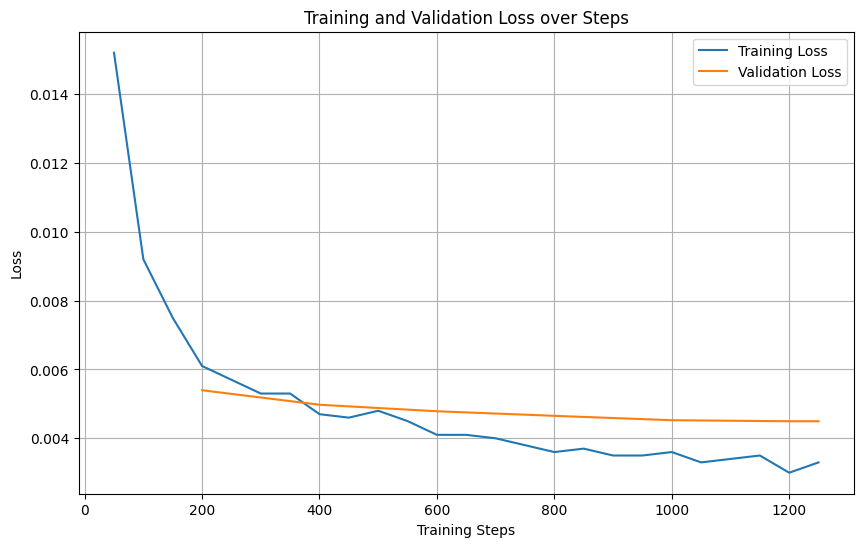

In [ ]:
log_history = trainer.state.log_history

# Extract steps and losses
train_steps = [x["step"] for x in log_history if "loss" in x]
train_losses = [x["loss"] for x in log_history if "loss" in x]

eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_losses = [x["eval_loss"] for x in log_history if "eval_loss" in x]

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label="Training Loss")
plt.plot(eval_steps, eval_losses, label="Validation Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Steps")
plt.legend()
plt.grid(True)
plt.show()

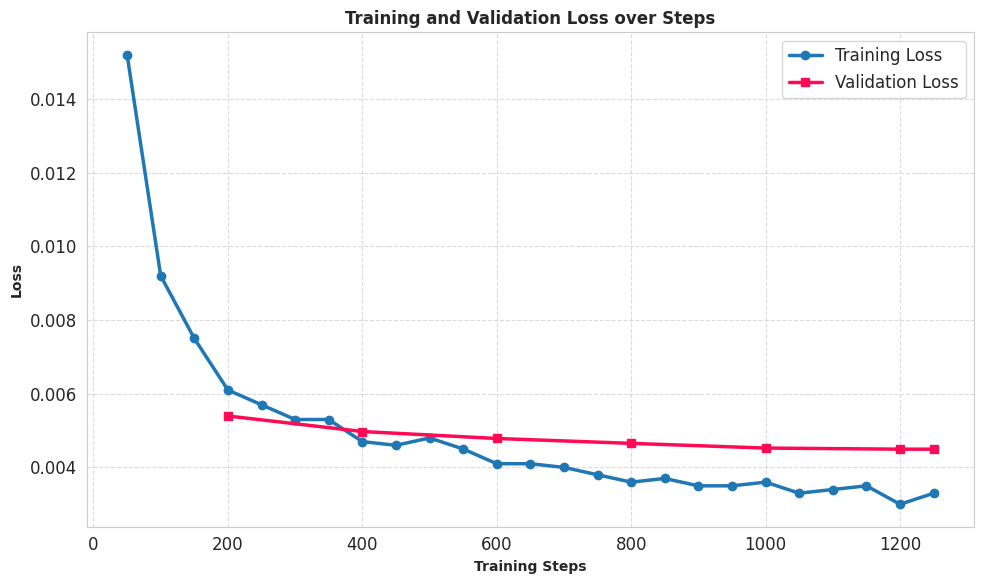

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'legend.fontsize': 12,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold'
})

# Extract steps and losses
train_steps = [x["step"] for x in trainer.state.log_history if "loss" in x]
train_losses = [x["loss"] for x in trainer.state.log_history if "loss" in x]
eval_steps = [x["step"] for x in trainer.state.log_history if "eval_loss" in x]
eval_losses = [x["eval_loss"] for x in trainer.state.log_history if "eval_loss" in x]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(
    train_steps,
    train_losses,
    label="Training Loss",
    color="#1f77b4",
    linewidth=2.5,    # Thicker line
    marker='o',       # Add markers for clarity
    markersize=6
)
plt.plot(
    eval_steps,
    eval_losses,
    label="Validation Loss",
    color="#FF0B55",
    linewidth=2.5,    # Thicker line
    marker='s',       # Different marker for distinction
    markersize=6
)

# Customize plot
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Steps")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
import time
import json
from transformers import TrainingArguments, Trainer

experiment_results = []

for exp in lora_experiments:
    print(f"\n=== Starting experiment: {exp['name']} ===")

    # Freeze base model parameters
    for param in model.parameters():
        param.requires_grad = False

    # Setup LoRA config for this experiment
    lora_config = LoraConfig(
        r=exp['r'],
        lora_alpha=exp['alpha'],
        target_modules=exp['target_modules'],
        lora_dropout=exp['dropout'],
        bias="none",
        task_type=TaskType.CAUSAL_LM,
    )
    lora_model = get_peft_model(model, lora_config)

    # Print trainable parameters
    trainable_params = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params:,}")

    # Setup TrainingArguments (update output_dir and learning_rate per experiment)
    training_args = TrainingArguments(
        output_dir=f"./lora-finetuned-gpt2-squad/{exp['name']}",
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=4,
        eval_strategy="steps",
        eval_steps=200,
        logging_steps=50,
        save_steps=200,
        save_total_limit=2,
        num_train_epochs=10,
        learning_rate=exp['learning_rate'],
        weight_decay=0.01,
        warmup_steps=100,
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
    )

    # Data collator
    data_collator = QADataCollator(tokenizer, max_length=512)

    # Initialize Trainer
    trainer = Trainer(
        model=lora_model,
        args=training_args,
        train_dataset=tok_train_ds,
        eval_dataset=tok_eval_ds,
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    # Train with timing
    start_time = time.time()
    trainer.train()
    end_time = time.time()

    train_time_sec = end_time - start_time
    print(f"Training time: {train_time_sec:.2f} seconds")

    # Evaluate validation loss
    eval_results = trainer.evaluate()
    val_loss = eval_results.get("eval_loss", None)
    print(f"Validation loss: {val_loss}")

    # Save the fine-tuned model and tokenizer for this experiment
    trainer.save_model(training_args.output_dir)
    tokenizer.save_pretrained(training_args.output_dir)

    # Append experiment results
    experiment_results.append({
        "name": exp["name"],
        "trainable_params": trainable_params,
        "val_loss": val_loss,
        "train_time": train_time_sec,
    })

# Save results to JSON file
with open("lora_experiment_results.json", "w") as f:
    json.dump(experiment_results, f, indent=4)

print("\nAll experiments finished!")


/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/tmp/ipython-input-50-1051236535.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



=== Starting experiment: exp_r4_lr1e-4_attn ===
Trainable parameters: 1,622,016


Step,Training Loss,Validation Loss
200,0.004400,0.005062
400,0.003500,0.005025
600,0.003400,0.004739
800,0.003200,0.004759
1000,0.003300,0.004645
1200,0.002800,0.004613


Training time: 1079.94 seconds


Validation loss: 0.004612790420651436


/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/tmp/ipython-input-50-1051236535.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



=== Starting experiment: exp_r8_lr2e-4_attn ===
Trainable parameters: 1,769,472


Step,Training Loss,Validation Loss
200,0.003600,0.004887
400,0.002900,0.004933
600,0.002900,0.004959
800,0.002500,0.004746
1000,0.002600,0.004672
1200,0.002200,0.004644


Training time: 1078.52 seconds


Validation loss: 0.004643510095775127


/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/tmp/ipython-input-50-1051236535.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



=== Starting experiment: exp_r16_lr5e-4_attn ===
Trainable parameters: 2,064,384


Step,Training Loss,Validation Loss
200,0.003100,0.004810
400,0.002200,0.004820
600,0.001900,0.005309
800,0.001500,0.005265
1000,0.001500,0.005287
1200,0.001100,0.005291


Training time: 1076.25 seconds


Validation loss: 0.00481032719835639


/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/tmp/ipython-input-50-1051236535.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



=== Starting experiment: exp_r8_lr2e-4_attn_mlp ===
Trainable parameters: 663,552


Step,Training Loss,Validation Loss
200,0.009300,0.007652
400,0.007000,0.006079
600,0.005600,0.005521
800,0.005800,0.005297
1000,0.005500,0.005176
1200,0.004800,0.005070


Training time: 1076.34 seconds


Validation loss: 0.005070437211543322


/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/tmp/ipython-input-50-1051236535.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



=== Starting experiment: exp_r32_lr2e-4_attn_mlp ===
Trainable parameters: 2,654,208


Step,Training Loss,Validation Loss
200,0.008500,0.007029
400,0.006600,0.005809
600,0.005300,0.005320
800,0.005500,0.005107
1000,0.005200,0.005002
1200,0.004500,0.004883


Training time: 1080.32 seconds


Validation loss: 0.0048828995786607265

All experiments finished!


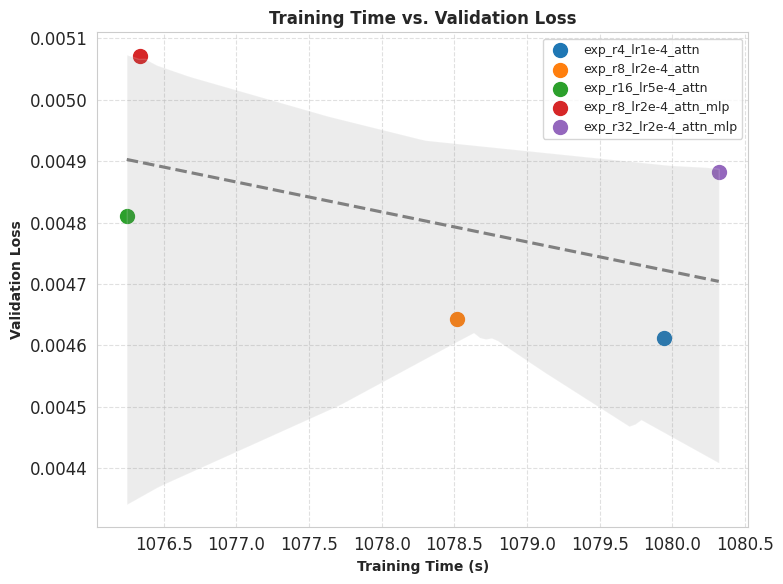

In [ ]:
plt.figure(figsize=(8, 6))

# Plot
for exp in experiment_results:
    plt.scatter(exp["train_time"], exp["val_loss"], label=exp["name"], s=100)

# Trend line (optional)
times = [e["train_time"] for e in experiment_results]
losses = [e["val_loss"] for e in experiment_results]
sns.regplot(x=times, y=losses, scatter=False, color='gray', line_kws={"linestyle": "--"})

plt.xlabel("Training Time (s)")
plt.ylabel("Validation Loss")
plt.title("Training Time vs. Validation Loss")
plt.legend(loc="best", fontsize=9)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

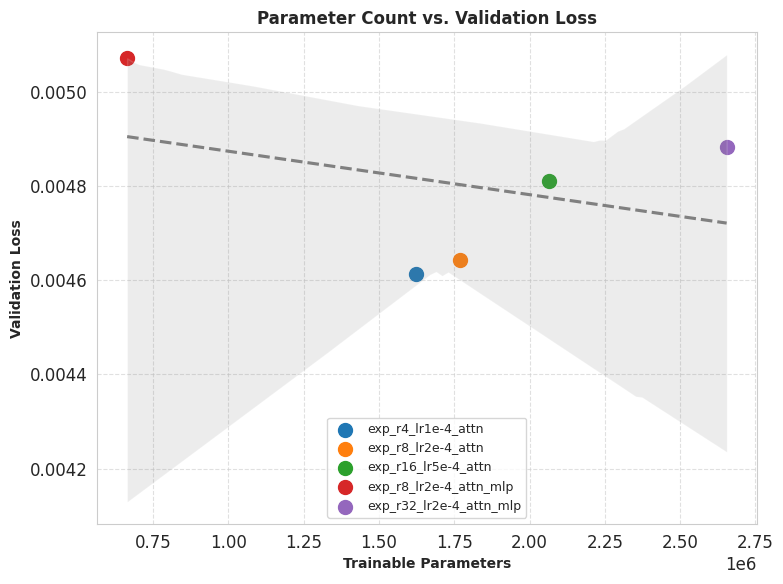

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Plot
for exp in experiment_results:
    plt.scatter(exp["trainable_params"], exp["val_loss"], label=exp["name"], s=100)

# Trend line (optional)
params = [e["trainable_params"] for e in experiment_results]
losses = [e["val_loss"] for e in experiment_results]
sns.regplot(x=params, y=losses, scatter=False, color='gray', line_kws={"linestyle": "--"})

plt.xlabel("Trainable Parameters")
plt.ylabel("Validation Loss")
plt.title("Parameter Count vs. Validation Loss")
plt.legend(loc="best", fontsize=9)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Short Answers :

In [ ]:
def extract_short_answer(text):
    # Try splitting by punctuation or newline, return first meaningful segment
    for sep in ['.', '\n', '?', '!']:
        if sep in text:
            return text.split(sep)[0].strip()
    return text.strip()

def generate_short_answer(model, tokenizer, context, question, max_new_tokens=50):
    """
    Generate answer for a given context and question using a causal language model.

    Args:
        model: The fine-tuned GPT-2 model with LoRA.
        tokenizer: Corresponding tokenizer with pad_token set.
        context: Passage text.
        question: The question string.
        max_new_tokens: Maximum tokens to generate for the answer.

    Returns:
        The generated answer string.
    """
    model.eval()

    prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.8,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    answer = generated_text.split("Answer:")[-1].strip()

    # Post-process to keep answer concise
    short_answer = extract_short_answer(answer)

    return short_answer

## complete answers :

In [ ]:
def generate_answer(model, tokenizer, context, question, max_new_tokens=50):
    """
    Generate answer for a given context and question using a causal language model.

    Args:
        model: The fine-tuned GPT-2 model with LoRA.
        tokenizer: Corresponding tokenizer with pad_token set.
        context: Passage text.
        question: The question string.
        max_new_tokens: Maximum tokens to generate for the answer.

    Returns:
        The generated answer string.
    """
    model.eval()

    prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.8,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the answer part (after "Answer:")
    answer = generated_text.split("Answer:")[-1].strip()

    if "\nQuestion:" in answer:
        answer = answer.split("\nQuestion:")[0].strip()

    return answer

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

# Path to saved model directory in Drive
model_path = "/content/drive/MyDrive/GPT2 Instruction Efficient Fine tuning/colab_session_backup/lora-finetuned-gpt2-squad-final"  # <-- adjust as needed

# Load the model with LoRA adapters
ft_model = AutoPeftModelForCausalLM.from_pretrained(model_path)
ft_model = ft_model.to("cuda" if torch.cuda.is_available() else "cpu")
ft_model.eval()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


## Generation Test :

In [ ]:
print("\n=== Testing Fine-tuned Model ===")
for i, example in enumerate(vali_ds):
    if i >= 3:
        break

    context = example["context"]
    question = example["question"]
    ground_truth = example["answers"]["text"][0] if example["answers"]["text"] else "N/A"

    # Generate answer
    predicted_answer = generate_answer(ft_model, tokenizer, context, question)
    predicted_short_answer = generate_short_answer(ft_model, tokenizer, context, question)

    print(f"\nExample {i+1}")
    print(f"Question: {question}")
    print(f"Context: {context[:200]}...")  # Truncate for readability
    print(f"Ground Truth: {ground_truth}")
    print(f"Predicted Answer: {predicted_answer}")
    print(f"Predicted short Answer: {predicted_short_answer}")
    print("---------------------")


=== Testing Fine-tuned Model ===

Example 1
Question: Which NFL team represented the AFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated...
Ground Truth: Denver Broncos
Predicted Answer: Denver Broncos. It is obvious that the AFC champion is Denver Broncos. The Broncos won the Super Bowl 51-7 over the Carolina Panthers 23–10, and then won Super Bowl 52-17 to take their third Super Bowl title. The New England
Predicted short Answer: Pittsburgh Steelers
---------------------

Example 2
Question: Which NFL team represented the NFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated...
Ground Truth: Carolina Panthers
Predicted Answer: Denv

## Evaluation Metrics :

In [ ]:
predictions = []
references = []

# Generate answers and collect predictions/references
for example in vali_ds:
    context = example["context"]
    question = example["question"]
    ground_truth = example["answers"]["text"][0] if example["answers"]["text"] else ""

    # Generate answer
    pred = generate_short_answer(ft_model, tokenizer, context, question)

    predictions.append({"id": example["id"], "prediction_text": pred})
    references.append({"id": example["id"], "answers": {"answer_start": [0], "text": [ground_truth]}})

# Load metric and compute
try:
    squad_metric = evaluate.load("squad")
    results = squad_metric.compute(predictions=predictions, references=references)
    print(f"\nSQuAD Metrics:\nExact Match: {results['exact_match']:.2f} | F1: {results['f1']:.2f}")
except Exception as e:
    print(f"Could not load SQuAD metric: {e}")
    print("Try installing with: pip install datasets[metrics]")


SQuAD Metrics:
Exact Match: 40.00 | F1: 40.00


In [ ]:
predictions = []
references = []

# Generate answers and collect predictions/references
for example in vali_ds:
    context = example["context"]
    question = example["question"]
    ground_truth = example["answers"]["text"][0] if example["answers"]["text"] else ""

    # Generate answer
    pred = generate_answer(ft_model, tokenizer, context, question)

    predictions.append({"id": example["id"], "prediction_text": pred})
    references.append({"id": example["id"], "answers": {"answer_start": [0], "text": [ground_truth]}})

# Load metric and compute
try:
    squad_metric = evaluate.load("squad")
    results = squad_metric.compute(predictions=predictions, references=references)
    print(f"\nSQuAD Metrics:\nExact Match: {results['exact_match']:.2f} | F1: {results['f1']:.2f}")
except Exception as e:
    print(f"Could not load SQuAD metric: {e}")
    print("Try installing with: pip install datasets[metrics]")


SQuAD Metrics:
Exact Match: 0.00 | F1: 10.04


## Personal Tests :

In [ ]:
context = (
    "Barack Obama served as the 44th President of the United States. "
    "His story is the American story — values from the heartland, a middle-class upbringing in a strong family, "
    "hard work and education as the means of getting ahead, and the conviction that a life so blessed should be lived in service to others."
)
question = "Who is the 44th president of the USA?"
print(generate_answer(ft_model, tokenizer, context, question))

Barack Obama.


In [ ]:
context = (
    "The Mona Lisa is a half-length portrait painting by Italian artist Leonardo da Vinci. "
    "Considered an archetypal masterpiece of the Italian Renaissance, it has been described as the best known, "
    "most visited, most written about, and most parodied work of art in the world."
)
question = "Who painted the Mona Lisa?"
print(generate_answer(ft_model, tokenizer, context, question))

Leonardo da Vinci


In [ ]:
context = (
    "Mount Everest is Earth's highest mountain above sea level, located in the Himalayas on the border between Nepal and the Tibet Autonomous Region of China. "
    "Its peak is 8,848 meters (29,029 feet) above sea level."
)
question = "Where is Mount Everest located?"
print(generate_answer(ft_model, tokenizer, context, question))

the Himalayas on the border between Nepal and the Tibet Autonomous Region of China. Mount Everest is 8,848 meters (29,029 feet) above sea level.


## Final Comparisson :

In [ ]:
import pandas as pd

# Data parsed from your logs
data = [
    {
        "Experiment": "exp_r4_lr1e-4_attn",
        "Trainable Params": 1_622_016,
        "Final Validation Loss": 0.004613,
        "Training Time (s)": 1079.94,
    },
    {
        "Experiment": "exp_r8_lr2e-4_attn",
        "Trainable Params": 1_769_472,
        "Final Validation Loss": 0.004644,
        "Training Time (s)": 1078.52,
    },
    {
        "Experiment": "exp_r16_lr5e-4_attn",
        "Trainable Params": 2_064_384,
        "Final Validation Loss": 0.004810,
        "Training Time (s)": 1076.25,
    },
    {
        "Experiment": "exp_r8_lr2e-4_attn_mlp",
        "Trainable Params": 663_552,
        "Final Validation Loss": 0.005070,
        "Training Time (s)": 1076.34,
    },
    {
        "Experiment": "exp_r32_lr2e-4_attn_mlp",
        "Trainable Params": 2_654_208,
        "Final Validation Loss": 0.004883,
        "Training Time (s)": 1080.32,
    },
]

df = pd.DataFrame(data)
df

,Experiment,Trainable Params,Final Validation Loss,Training Time (s)
0,exp_r4_lr1e-4_attn,1622016,0.004613,1079.94
1,exp_r8_lr2e-4_attn,1769472,0.004644,1078.52
2,exp_r16_lr5e-4_attn,2064384,0.004810,1076.25
3,exp_r8_lr2e-4_attn_mlp,663552,0.005070,1076.34
4,exp_r32_lr2e-4_attn_mlp,2654208,0.004883,1080.32


## Baseline model comparisson

In [ ]:
baseline_model_name = "gpt2"
baseline_tokenizer = AutoTokenizer.from_pretrained(baseline_model_name)
baseline_model = AutoModelForCausalLM.from_pretrained(baseline_model_name).to("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
baseline_predictions = []
ft_predictions = []
references = []

device = "cuda" if torch.cuda.is_available() else "cpu"

for example in vali_ds:  # your validation dataset here
    context = example["context"]
    question = example["question"]
    ground_truth = example["answers"]["text"][0]  # assuming at least one answer

    # Baseline prediction
    baseline_pred = generate_answer(baseline_model, baseline_tokenizer, context, question)
    # Fine-tuned prediction
    ft_pred = generate_answer(ft_model, tokenizer, context, question)

    # Append for metric computation
    baseline_predictions.append({"id": example["id"], "prediction_text": baseline_pred})
    ft_predictions.append({"id": example["id"], "prediction_text": ft_pred})
    references.append({"id": example["id"], "answers": example["answers"]})

# Compute metrics
baseline_results = squad_metric.compute(predictions=baseline_predictions, references=references)
ft_results = squad_metric.compute(predictions=ft_predictions, references=references)

print("Baseline GPT-2 Performance:")
print(baseline_results)

print("\nFine-tuned LoRA GPT-2 Performance:")
print(ft_results)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Baseline GPT-2 Performance:
{'exact_match': 0.0, 'f1': 2.5531914893617023}

Fine-tuned LoRA GPT-2 Performance:
{'exact_match': 20.0, 'f1': 34.39613526570049}


In [ ]:
for i in range(3):  # show 3 examples
    print(f"Example {i+1}")
    print("Question:", vali_ds[i]["question"])
    print("Context:", vali_ds[i]["context"])
    print("Ground truth:", vali_ds[i]["answers"]["text"][0])
    print("Baseline GPT-2 answer:", baseline_predictions[i]["prediction_text"])
    print("Fine-tuned LoRA answer:", ft_predictions[i]["prediction_text"])
    print("-----\n")

Example 1
Question: Which NFL team represented the AFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Ground truth: Denver Broncos
Baseline GPT-2 answer: The Cleveland Browns (8-2, 2–0 in Super Bowl 50), Houston Texans (9-3, 0–0 in Super Bowl 5

## Answer generation Strategies:

In [ ]:
def generate_answer_strategy(
    model,
    tokenizer,
    context,
    question,
    max_new_tokens=50,
    do_sample=False,
    top_k=0,
    top_p=1.0,
    temperature=1.0,
):
    model.eval()
    prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=do_sample,
            top_k=top_k,
            top_p=top_p,
            temperature=temperature,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    return decoded.split("Answer:")[-1].strip()

In [ ]:
decoding_configs = [
    {"name": "Greedy", "do_sample": False},
    {"name": "Top-k (10)", "do_sample": True, "top_k": 10, "temperature": 1.0},
    {"name": "Top-k (25)", "do_sample": True, "top_k": 25, "temperature": 1.0},
    {"name": "Top-k (50)", "do_sample": True, "top_k": 50, "temperature": 1.0},
    {"name": "Nucleus (p=0.8)", "do_sample": True, "top_p": 0.8, "temperature": 1.0},
    {"name": "Nucleus (p=0.9)", "do_sample": True, "top_p": 0.9, "temperature": 1.0},
    {"name": "Nucleus (p=0.95)", "do_sample": True, "top_p": 0.95, "temperature": 1.0},
    {"name": "Temp 0.7", "do_sample": True, "top_k": 50, "temperature": 0.7},
    {"name": "Temp 1.3", "do_sample": True, "top_k": 50, "temperature": 1.3},
]

In [ ]:
results = []

# Loop through decoding configs
for config in decoding_configs:
    predictions = []
    references = []

    print(f"\nEvaluating: {config['name']}")
    for example in vali_ds.select(range(5)):  # use a subset for speed
        context = example["context"]
        question = example["question"]
        ground_truth = example["answers"]["text"][0]

        answer = generate_answer_strategy(
            model=ft_model,
            tokenizer=tokenizer,
            context=context,
            question=question,
            max_new_tokens=50,
            do_sample=config.get("do_sample", False),
            top_k=config.get("top_k", 0),
            top_p=config.get("top_p", 1.0),
            temperature=config.get("temperature", 1.0),
        )

        predictions.append({"id": example["id"], "prediction_text": answer})
        references.append({"id": example["id"], "answers": example["answers"]})

    metric_result = squad_metric.compute(predictions=predictions, references=references)
    print(f"{config['name']}: EM={metric_result['exact_match']:.2f}, F1={metric_result['f1']:.2f}")

    results.append({
        "strategy": config["name"],
        "exact_match": metric_result["exact_match"],
        "f1": metric_result["f1"],
    })

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Evaluating: Greedy


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Greedy: EM=0.00, F1=20.22

Evaluating: Top-k (10)
Top-k (10): EM=0.00, F1=7.06

Evaluating: Top-k (25)
Top-k (25): EM=0.00, F1=9.93

Evaluating: Top-k (50)
Top-k (50): EM=0.00, F1=8.76

Evaluating: Nucleus (p=0.8)
Nucleus (p=0.8): EM=0.00, F1=6.46

Evaluating: Nucleus (p=0.9)
Nucleus (p=0.9): EM=0.00, F1=5.05

Evaluating: Nucleus (p=0.95)
Nucleus (p=0.95): EM=0.00, F1=7.33

Evaluating: Temp 0.7
Temp 0.7: EM=0.00, F1=11.72

Evaluating: Temp 1.3
Temp 1.3: EM=0.00, F1=8.28


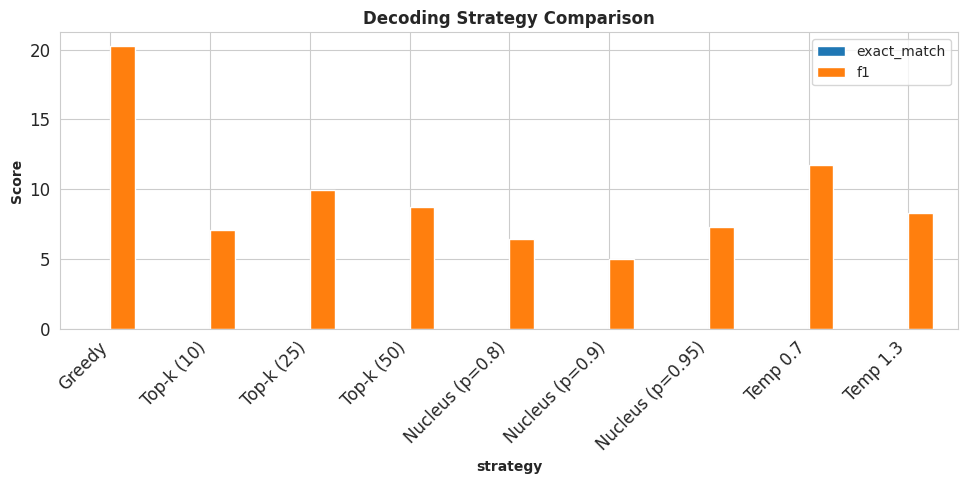

In [ ]:
df = pd.DataFrame(results)
df.plot(x="strategy", y=["exact_match", "f1"], kind="bar", figsize=(10, 5))
plt.title("Decoding Strategy Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()